# Import and Load Data

In [1]:
import re
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models, layers,  Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")

In [3]:
pd.set_option("max.colwidth",0)

In [4]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

# Preprocessing

In [5]:
# Preprocessing Function 

def preprocessing(sentence):
    sentence = sentence.replace("<br /><br />","")
    sentence = re.sub('<[^<]+?>','', sentence)
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = ''.join(c for c in sentence if not c.isdigit())
    
    for pun in string.punctuation:
        sentence = sentence.replace(pun, '')
    tokens = word_tokenize(sentence)
    
    lem_word = [WordNetLemmatizer().lemmatize(word, pos='n') for word in [WordNetLemmatizer().lemmatize(words, pos='v') 
                                                                          for words in tokens]]
    sentence =  ' '.join(lem_word)
    
    return sentence

In [6]:
%%time
df['cleaned_reviews'] = df['review'].apply(preprocessing)

CPU times: user 56.7 s, sys: 36 ms, total: 56.7 s
Wall time: 57.2 s


In [7]:
# Encoding target
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)

In [8]:
df.head(1)

,review,sentiment,cleaned_reviews
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",1,one of the other reviewer have mention that after watch just oz episode youll be hook they be right a this be exactly what happen with methe first thing that strike me about oz be it brutality and unflinching scene of violence which set in right from the word go trust me this be not a show for the faint hearted or timid this show pull no punch with regard to drug sex or violence it be hardcore in the classic use of the wordit be call oz a that be the nickname give to the oswald maximum security state penitentary it focus mainly on emerald city an experimental section of the prison where all the cell have glass front and face inwards so privacy be not high on the agenda em city be home to manyaryans muslim gangsta latino christian italian irish and moreso scuffle death star dodgy deal and shady agreement be never far awayi would say the main appeal of the show be due to the fact that it go where other show wouldnt dare forget pretty picture paint for mainstream audience forget charm forget romanceoz doesnt mess around the first episode i ever saw strike me a so nasty it be surreal i couldnt say i be ready for it but a i watch more i develop a taste for oz and get accustom to the high level of graphic violence not just violence but injustice crook guard wholl be sell out for a nickel inmate wholl kill on order and get away with it well mannered middle class inmate be turn into prison bitch due to their lack of street skill or prison experience watch oz you may become comfortable with what be uncomfortable viewingthats if you can get in touch with your darker side


In [9]:
X = df["cleaned_reviews"]
y = np.asarray(df['sentiment'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [11]:
X_train.shape

(40000,)

In [12]:
y_train.shape

(40000,)

# Padding

In [13]:
X_train = X_train.tolist()
X_test = X_test.tolist()

In [14]:
X_train_list = [word.split() for word in X_train]
X_test_list = [word.split() for word in X_test]

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_list)

X_train_token = tokenizer.texts_to_sequences(X_train_list)
X_test_token = tokenizer.texts_to_sequences(X_test_list)

In [16]:
joblib.dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [17]:
vocab_size = len(tokenizer.word_index)
vocab_size

167202

In [18]:
# Identify the max lenght of review
max_length = 0
for review_number in range(len(X_train_token)):
    numberofwords = len(X_train_token[review_number])
    if numberofwords > max_length:
        max_length = numberofwords
max_length

2441

In [19]:
X_train_pad = pad_sequences(X_train_token, maxlen=max_length)
X_test_pad = pad_sequences(X_test_token, maxlen=max_length)

print("Shape of Padded Train Data:", X_train_pad.shape)
print("Shape of Padded Test Data:", X_test_pad.shape)

Shape of Padded Train Data: (40000, 2441)
Shape of Padded Test Data: (10000, 2441)


# Model defination

In [20]:
def initialize_model(input_dim, input_length, output_dim=30):
    
    model=Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        LSTM(50),
        Dense(20,activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    
    
    ### Model compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


    return model

# Train the Model

In [21]:
input_dim = vocab_size+1
input_length = max_length
model = initialize_model(input_dim, input_length)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2441, 30)          5016090   
                                                                 
 lstm (LSTM)                 (None, 50)                16200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,033,331
Trainable params: 5,033,331
Non-trainable params: 0
_________________________________________________________________


In [23]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
          epochs=10,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/10


2024-03-16 17:18:28.330580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1000/1000 [==============================] - 417s 416ms/step - loss: 0.4300 - accuracy: 0.8026 - val_loss: 0.3369 - val_accuracy: 0.8577
Epoch 2/10
1000/1000 [==============================] - 420s 420ms/step - loss: 0.2090 - accuracy: 0.9213 - val_loss: 0.3333 - val_accuracy: 0.8731
Epoch 3/10
1000/1000 [==============================] - 420s 420ms/step - loss: 0.1138 - accuracy: 0.9605 - val_loss: 0.3761 - val_accuracy: 0.8664
Epoch 4/10
1000/1000 [==============================] - 652s 652ms/step - loss: 0.0730 - accuracy: 0.9757 - val_loss: 0.4385 - val_accuracy: 0.8656
Epoch 5/10
1000/1000 [==============================] - 420s 420ms/step - loss: 0.0582 - accuracy: 0.9802 - val_loss: 0.4985 - val_accuracy: 0.8637
Epoch 6/10
1000/1000 [==============================] - 417s 417ms/step - loss: 0.0390 - accuracy: 0.9866 - val_loss: 0.8094 - val_accuracy: 0.8534
Epoch 7/10
1000/1000 [==============================] - 420s 420ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.639

# Evaluate the Model and Display the results

In [24]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY ---

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

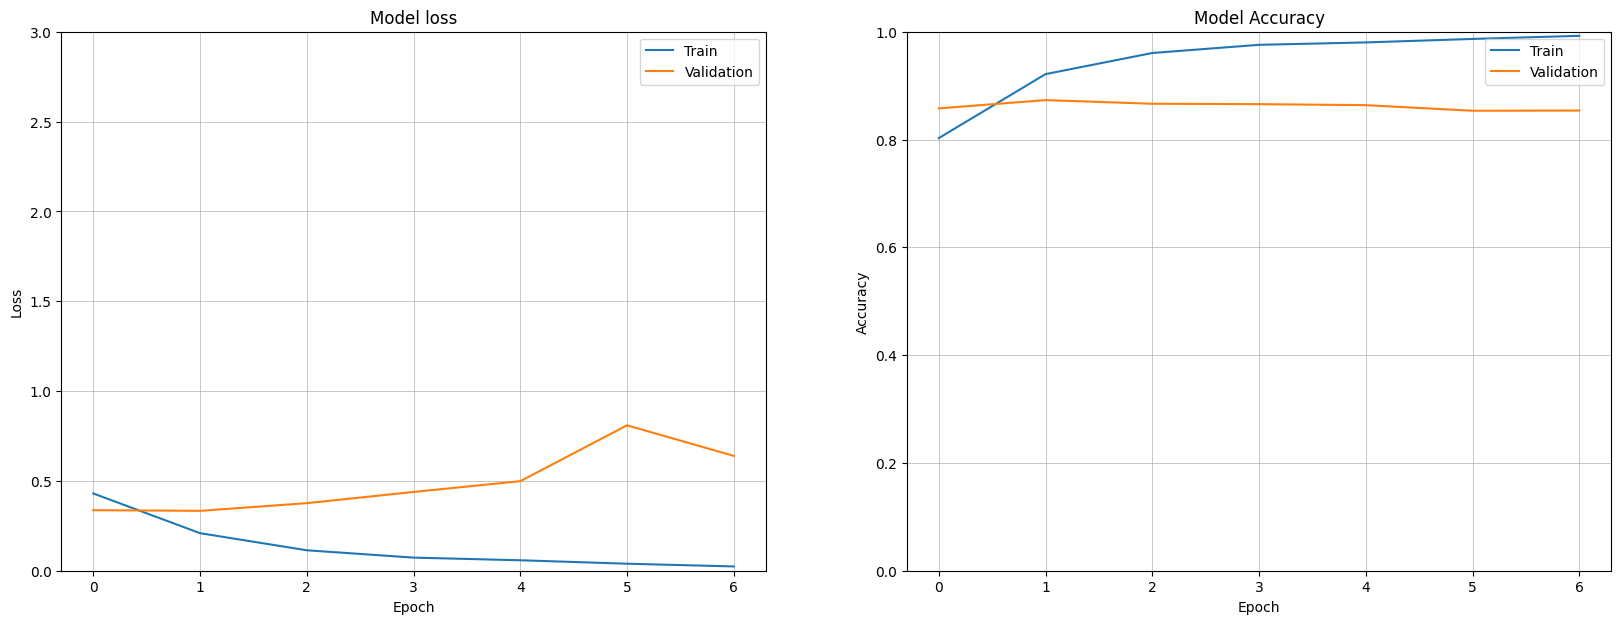

In [25]:
plot_loss_accuracy(history, title=None)

In [26]:
evaluation = model.evaluate(X_test_pad, y_test)
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

313/313 [==============================] - 26s 82ms/step - loss: 0.3070 - accuracy: 0.8832
Model accuracy is 88.32 %


In [27]:
y_pred = model.predict(X_test_pad)

313/313 [==============================] - 26s 82ms/step


In [28]:
y_pred

array([[0.00495519],
       [0.9694232 ],
       [0.02584473],
       ...,
       [0.9778425 ],
       [0.01835246],
       [0.95650464]], dtype=float32)

# Save the Model

In [29]:
model.save('rnn_model.h5')

In [30]:
 #load it somewhere else:
loaded_model = models.load_model('rnn_model.h5')

In [31]:
loaded_model.predict(X_test_pad[0:10])

1/1 [==============================] - 0s 210ms/step


array([[0.00495519],
       [0.9694232 ],
       [0.02584473],
       [0.9714854 ],
       [0.01300135],
       [0.97595614],
       [0.9441029 ],
       [0.01371467],
       [0.02333857],
       [0.00898713]], dtype=float32)

In [32]:
y_test[:10]

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0])